# Performance Evaluation

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline

# Regression Performance
- MAE (mean absolute error)
- MSE (mean square error)
- RMSE (root mean square error)
- R-squared 



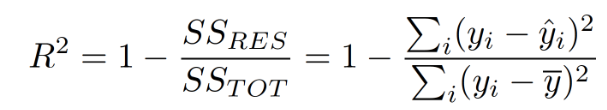

# Classification Performance 
- 분류 알고리즘 비교
  - 리지 규제, 라쏘 규제
  - 교차검증
  - 정적 성능평가 Confusion matrix  
  - 동적 성능평가 ROC

- Data
  - 포도주 품질 분류 https://goo.gl/Gyc8K7
  - https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine/notebook



## Data (포도주 품질 평가 데이터)

In [27]:
!curl -L https://goo.gl/Gyc8K7 -o winequality-red.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   144    0   144    0     0    282      0 --:--:-- --:--:-- --:--:--   282
100   318  100   318    0     0    474      0 --:--:-- --:--:-- --:--:--   474
100   98k  100   98k    0     0  83776      0  0:00:01  0:00:01 --:--:--  207k


In [28]:
wine = pd.read_csv('./winequality-red.csv')
print(wine.shape)
wine.head(5)

(1599, 12)


fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.4              0.70         0.00  ...       0.56      9.4        5
1            7.8              0.88         0.00  ...       0.68      9.8        5
2            7.8              0.76         0.04  ...       0.65      9.8        5
3           11.2              0.28         0.56  ...       0.58      9.8        6
4            7.4              0.70         0.00  ...       0.56      9.4        5

[5 rows x 12 columns]

- fixed acidity - 결합 산도 
- volatile acidity - 휘발성 산도 
- citric acid - 시트르산 
- residual sugar - 잔류 설탕 
- chlorides	 - 염화물 
- free sulfur dioxide - 자유 이산화황 
- total sulfur dioxide - 총 이산화황 
- density - 밀도 
- pH - pH 
- sulphates - 황산염 
- alcohol - 알코올 
- quality - 품질 (0 ~ 10 점)

In [29]:
wine.info() # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## Preprocessing (Label 만들기)

In [30]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [31]:
# 품질이 좋고 나쁜 것을 나누는 기준 설정
# 6.5를 기준으로 bad(0) good(1)으로 나눈다 (임의로 나눈 것임)
my_bins = (2.5, 6.5, 8.5)
groups = [0, 1]
wine['qual'] = pd.cut(wine['quality'], bins = my_bins, labels = groups) 

wine['qual'].value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [32]:
X = wine.drop(['quality', 'qual'], axis = 1) 
y = wine['qual'] 

y.value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [33]:
X[:3]

fixed acidity  volatile acidity  citric acid  ...    pH  sulphates  alcohol
0            7.4              0.70         0.00  ...  3.51       0.56      9.4
1            7.8              0.88         0.00  ...  3.20       0.68      9.8
2            7.8              0.76         0.04  ...  3.26       0.65      9.8

[3 rows x 11 columns]

## Standard Scaling (표준 스케일링)
- transform the dataset to Gaussian dist (0, 1) - numerical features only
- test dataset should also be scaled

In [34]:
sc = StandardScaler()
X = sc.fit_transform(X)  # fit and transform

In [35]:
X[:3]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711]])

In [36]:
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1279, 11), (1279,), (320, 11), (320,))

## Linear model (Stochastic Gradient Descent method)

In [37]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd.score(X_test,y_test)

0.81875

## Decesion Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
clf.score(X_train,y_train), clf.score(X_test,y_test)

(0.9335418295543393, 0.878125)

## Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=300, max_depth=5) 
rfc.fit(X_train, y_train)
rfc.score(X_train,y_train), rfc.score(X_test,y_test)

(0.9296325254104769, 0.88125)

## Support Vector Classifier (SVC)

In [40]:
svc = SVC()   # default: C=1.0, kernel='rbf', gamma='scale' 
svc.fit(X_train, y_train)
svc.score(X_train,y_train), svc.score(X_test,y_test)

(0.8991399530883503, 0.88125)

Logistic Regression
--

In [41]:
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_train,y_train), log.score(X_test,y_test)

(0.8819390148553558, 0.86875)

## Cross validation(교차 검증)

In [42]:
# estimator = 모델, cv는 분할 블록의 갯수
rfc_eval = cross_val_score(rfc, X, y, cv = 5)  
rfc_eval, rfc_eval.mean()

(array([0.875     , 0.871875  , 0.875     , 0.86875   , 0.88401254]),
 0.8749275078369905)

##  Performance : 정적 평가, 혼돈 매트릭스 (confusion_matrix)

In [43]:
y_pred = sgd.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[253,  16],
       [ 42,   9]])

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       269
           1       0.36      0.18      0.24        51

    accuracy                           0.82       320
   macro avg       0.61      0.56      0.57       320
weighted avg       0.78      0.82      0.79       320



## Score (or Probability)

In [45]:
y_score = sgd.decision_function(X_test)   # sgd 는 predict_proba() 가 없음
# decision_function(): The confidence score for a sample is the signed distance 
# of that sample to the hyperplane (proportional to the signed distance of that 
# sample to the hyperplane)

In [46]:
y_score[:5]

array([ 0.79259076, -2.95713556, -5.74014753, -1.21517746, -5.88022051])

## Ranking (순서를 평가)

In [47]:
result = pd.DataFrame(list(zip(y_score, y_pred, y_test)), 
                      columns=['score', 'predict', 'real'])
result['correct'] = (result.predict == result.real)
result.head()

score  predict  real  correct
0  0.792591        1     0    False
1 -2.957136        0     0     True
2 -5.740148        0     0     True
3 -1.215177        0     0     True
4 -5.880221        0     0     True

## ROC and AUC (맞춘 순서로 평가)

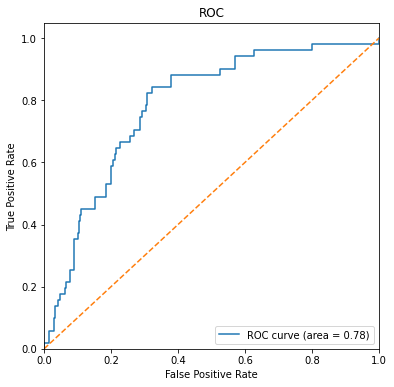

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

## Precision-Recall curve

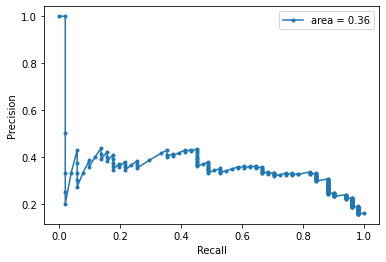

In [49]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
auc_score = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='area = %0.2f' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()